# Load Packages

In [ ]:
!pip install jaxopt
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
!sudo apt-get install cm-super dvipng

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cm-super is already the newest version (0.3.4-15).
dvipng is already the newest version (1.15-1.1).
texlive-latex-extra is already the newest version (2019.202000218-1).
texlive-latex-recommended is already the newest version (2019.20200218-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cm-super is already the newest version (0.3.4-15).
dvipng is already the newest version (1.15-1.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import jax
import jax.numpy as jnp
import jaxopt
import numpy as np
import optax
import cvxpy
import matplotlib.pyplot as plt
from jaxopt import ProjectedGradient
import functools
import seaborn as sns
np.set_printoptions(precision=4)
jnp.set_printoptions(precision=4, formatter={'float': lambda x: "{0:0.4f}".format(x)})
plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

In [ ]:
seed = 42
random_seeds = [5, 12, 34, 42, 71]

# Utility Functions

In [ ]:

############# Important Utility Function Definitions #############

# Linear utility function: Perfect Substitutes
@jax.jit
def get_linear_utility(allocation, valuations):
    # Returns utility value for linear agent
    return allocation.T @ valuations

# Quasilinear utility function
@jax.jit
def get_quasilinear_utility(allocation, valuations, prices):
    # Returns utility value for linear agent
    return allocation.T @ (valuations - prices)

# CES utility Function, - infinity < rho < 1
@jax.jit
def get_ces_utility(allocation, valuations, rho):
    # Returns utility value for CES agent
    return jnp.power(np.power(allocation, rho).T @ valuations, (1/rho))

# Leontief utility function: Perfect Complements
@jax.jit
def get_leontief_utility(allocation, valuations):
    return jnp.min(allocation/valuations)

# Cobb-Douglas utility function
@jax.jit
def get_CD_utility(allocation, valuations):
    # For easy of calculation, normalize valautions
    # This does not change the preference relation that the utility function represents
    normalized_vals = valuations / jnp.sum(valuations)
    return jnp.prod(jnp.power(allocation, normalized_vals))
    
############# Economic Function Definitions #############

###### Define UMP and EMP functions for Custom utility functions ######


def get_custom_ump(prices, budget, util_func):
    """
    Inputs: 
        prices: A vector of non-negative prices
        budget: A non-negative scalar valued budget
        util_func: A utility function which takes as input a vector of allocation and ouputs utility
        Note that the utility function should already be parametrized when inputted into the function
    Returns:
        (indirect_utility, marshallian_demand): A UMP solution pair
            indirect_utility: The maximum utility achievable at inputted prices and budget
            marshallian_demand: The vector of goods that maximizes utility constrained by budget
    """

    allocation = cp.Variable(prices.shape[0])
    obj = cp.Maximize(util_func(allocation))
    constr = [allocation.T @ prices <= budget,
                allocation >= 0 ]
    program = cp.Problem(obj, constr)

    indirect_util = program.solve()
    marshallian_demand = allocation.value

    return (indirect_util, marshallian_demand)

def get_custom_indirect_util(prices, budget, util_func):
    return get_custom_ump(prices, budget, util_func)[0]

def get_custom_marshallian_demand(prices, budget, util_func):
    return get_custom_ump(prices, budget, util_func)[1]

def get_custom_emp(prices, util_level, util_func):
    """
    Inputs: 
        prices: A vector of non-negative prices
        budget: A non-negative utility level that the buyer wants to at least achieve
        util_func: A utility function which takes as input a vector of allocation and ouputs utility
        Note that the utility function should already be parametrized when passed into the function
    Returns:
        (expenditure, hicksian_demand): A EMP solution pair
            expenditure: The minimum spending needed to achieve a utility level of 
                util_level at inputted prices
            hicksian: The vector of goods that achieves util_level units of utility and 
                minimizes expenditure at inputted prices
    """
    allocation = cp.Variable(prices.shape[0])
    obj = cp.Minimize(prices.T @ allocation)
    constr = [util_func(allocation) >= util_level,
              allocation >= 0 ]
    program = cp.Problem(obj, constr)

    expenditure = program.solve()
    hicksian_demand = allocation.value

    return (expenditure, hicksian_demand)

def get_custom_expend(prices, util_level, util_func):
    # Returns the expenditure for linear utility
    return get_custom_emp(prices, util_level, util_func)[0]

def get_custom_hicksian_demand(prices, util_level, util_func):
    # Returns the hicksian demand for linear utilities
    return get_custom_emp(prices, util_level, util_func)[1]


###### Define UMP and EMP functions for Leontief, Cobb-Douglas and CES utility functions ######
# Recall that closed form solutions exist for the UMP and EMP problem for both of these function


######    Linear Utilities    ######
@jax.jit
def get_linear_indirect_util(prices, budget, valuations):
    return jnp.max(valuations/prices)*budget

@jax.jit
def get_linear_marshallian_demand(prices, budget, valuations):
    max_bang_buck_goods = (valuations/prices >= jnp.max(valuations/prices))
    cost = max_bang_buck_goods.T @ prices
    
    return max_bang_buck_goods*(budget/cost)

@jax.jit
def get_linear_expend(prices, util, valuations):
    return jnp.min(prices/valuations)*util

###### Cobb-Douglas Utilities ######

@jax.jit
def get_CD_marshallian_demand(prices, budget, valuations):
    normalized_vals = valuations / jnp.sum(valuations)
    return normalized_vals*budget/prices

@jax.jit
def get_CD_indirect_util(prices, budget, valuations):
    return get_CD_utility(get_CD_marshallian_demand(prices, budget, valuations), valuations)

@jax.jit
def get_CD_ump(prices, budget, valuations):
    """
    Inputs: 
        prices: A vector of non-negative prices
        budget: A non-negative scalar valued budget
        valuations: A vector of valuations that parametrizes Cobb-Douglas utilities
    Returns:
        (indirect_utility, marshallian_demand): A UMP solution pair
            indirect_utility: The maximum utility achievable at inputted prices and budget
            marshallian_demand: The vector of goods that maximizes utility constrained by budget
    """
    indirect_util = get_CD_indirect_util(prices, budget, valuations)
    marshallian_demand = get_CD_marshallian_demand(prices, budget, valuations)

    return (indirect_util, marshallian_demand)

@jax.jit
def get_CD_expend(prices, util, valuations):
    normalized_vals = valuations / jnp.sum(valuations)
    K = 1/jnp.prod((jnp.power(normalized_vals, normalized_vals)))
    return K*jnp.prod(jnp.power(prices, normalized_vals))*util

@jax.jit
def get_CD_hicksian_demand(prices, util, valuations):
    return get_CD_marshallian_demand(prices, get_CD_expend(prices, util, valuations), valuations)

@jax.jit
def get_CD_emp(prices, util_level, valuations):
    """
    Inputs: 
        prices: A vector of non-negative prices
        budget: A non-negative utility level that the buyer wants to at least achieve
        valuations: A vector of valuations that parametrizes the Cobb-Douglas utility
    Returns:
        (expenditure, hicksian_demand): A EMP solution pair
            expenditure: The minimum spending needed to achieve a utility level of 
                util_level at inputted prices
            hicksian: The vector of goods that achieves util_level units of utility and 
                minimizes expenditure at inputted prices
    """
    expenditure = get_CD_expend(prices, util_level, valuations)
    hicksian_demand = get_CD_hicksian_demand(prices, util_level, valuations)

    return (expenditure, hicksian_demand)

###### Leontief Utilities ######

@jax.jit
def get_leontief_indirect_util(prices, budget, valuations):
    return budget/(prices.T @ valuations)

@jax.jit
def get_leontief_marshallian_demand(prices, budget, valuations):
    return (budget/(prices.T @ valuations)) * valuations
@jax.jit
def get_leontief_ump(prices, budget, valuations):
    """
    Inputs: 
        prices: A vector of non-negative prices
        budget: A non-negative scalar valued budget
        valuations: A vector of valuations that parametrizes the Leontief utility
    Returns:
        (indirect_utility, marshallian_demand): A UMP solution pair
            indirect_utility: The maximum utility achievable at inputted prices and budget
            marshallian_demand: The vector of goods that maximizes utility constrained by budget
    """
    indirect_util = get_leontief_indirect_util(prices, budget, valuations)
    marshallian_demand = get_leontief_marshallian_demand(prices, budget, valuations)

    return (indirect_util, marshallian_demand)

@jax.jit
def get_leontief_expend(prices, util_level, valuations):
    return util_level*(prices.T @ valuations)

@jax.jit
def get_leontief_hicksian_demand(prices, util_level, valuations):
    return valuations*util_level

@jax.jit
def get_leontief_emp(prices, util_level, valuations):
    """
    Inputs: 
        prices: A vector of non-negative prices
        budget: A non-negative utility level that the buyer wants to at least achieve
        valuations: A vector of valuations that parametrizes the Leontief utility
    Returns:
        (expenditure, hicksian_demand): A EMP solution pair
            expenditure: The minimum spending needed to achieve a utility level of 
                util_level at inputted prices
            hicksian: The vector of goods that achieves util_level units of utility and 
                minimizes expenditure at inputted prices
    """
    expenditure = get_leontief_expend(prices, util_level, valuations)
    hicksian_demand = get_leontief_hicksian_demand(prices, util_level, valuations)

    return (expenditure, hicksian_demand)

###### CES Utilities ######

def get_ces_indirect_util(prices, budget, valuations, rho):
    sigma = 1/(1-rho)
    v = jnp.power(valuations, sigma)
    p = jnp.power(prices, 1-sigma)
    cost_unit_util = jnp.power(v.T @ p, 1/(1-sigma))
    return budget/cost_unit_util

def get_ces_marshallian_demand(prices, budget, valuations, rho):
    v = jnp.power(valuations, 1/(1-rho))
    p_num = jnp.power(prices, 1/(rho-1))
    p_denom = jnp.power(prices, rho/(rho-1))
    return budget* ((v*p_num)/ (v.T @ p_denom))

def get_ces_ump(prices, budget, valuations, rho):
    """
    Inputs: 
        prices: A vector of non-negative prices
        budget: A non-negative scalar valued budget
        valuations: A vector of valuations that parametrizes the CES utility
    Returns:
        (indirect_utility, marshallian_demand): A UMP solution pair
            indirect_utility: The maximum utility achievable at inputted prices and budget
            marshallian_demand: The vector of goods that maximizes utility constrained by budget
    """
    indirect_util = get_ces_indirect_util(prices, budget, valuations, rho)
    marshallian_demand = get_ces_marshallian_demand(prices, budget, valuations, rho)

    return (indirect_util, marshallian_demand)

def get_ces_expend(prices, util_level, valuations, rho):
    # Returns the expenditure for CES utility
    sigma = 1/(1-rho)
    v = jnp.power(valuations, sigma)
    p = jnp.power(prices, 1-sigma)
    cost_unit_util = jnp.power(v.T @ p, 1/(1-sigma))
    return util_level*cost_unit_util

def get_ces_hicksian_demand(prices, util_level, valuations ,rho):
    # Returns the hicksian demand for CES utilities
    expenditure = get_ces_expend(prices, util_level, valuations, rho)
    return get_ces_marshallian_demand(prices, expenditure, valuations, rho)
    
def get_ces_emp(prices, util_level, valuations, rho):
    """
    Inputs: 
        prices: A vector of non-negative prices
        budget: A non-negative utility level that the buyer wants to at least achieve
        valuations: A vector of valuations that parametrizes the CES utility
        rho: The elasticity of substitution of the utility function
    Returns:
        (expenditure, hicksian_demand): A EMP solution pair
            expenditure: The minimum spending needed to achieve a utility level of 
                util_level at inputted prices
            hicksian: The vector of goods that achieves util_level units of utility and 
                minimizes expenditure at inputted prices
    """
    expenditure = get_ces_expend(prices, util_level, valuations, rho)
    hicksian_demand = get_ces_hicksian_demand(prices, util_level, valuations, rho)

    return (expenditure, hicksian_demand)

# Auxiliary Functions

In [ ]:
def sample_markets(num_buyers: int, num_goods: int, num_samples: int, subst_range: float,
                   seed: int) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """Returns sampled markets for training, validation, and testing.
    Args:
      num_buyers: Number of buyers in the markets
      num_goods: Number of goods in the markets
      num_samples: Number of total markets to sample
      num_train: Number of training markets to sample
      num_valid: Number of validation markets to sample
      subst_range: Point around which rho parameter is centered
      seed: Seed for the PRNG
    Returns:
      A tuple which consists of three jnp.ndarray which respectively correspond to
      training, validation, and testing markets.
    """
    valuations_key, endowments_key, rho_key = jax.random.split(
        jax.random.PRNGKey(seed), 3)
    valuations = jax.random.uniform(
        valuations_key,
        shape=(num_samples, num_buyers, num_goods),
        minval=5,
        maxval=10)
    endowments = jax.random.uniform(
        endowments_key,
        shape=(num_samples, num_buyers, num_goods),
        minval=1e-8,
        maxval=1.0)
    endowments /= jnp.sum(endowments, axis = 1, keepdims=True)
    assert jnp.sum(endowments, axis = 0).all() == 1
    if subst_range == 0.0:
        rho_1 = jax.random.uniform(
            rho_key,
            shape=(int(num_samples / 2), num_buyers),
            minval=(0.5 - 0.25),
            maxval=(0.5 + 0.25))
        rho_2 = jax.random.uniform(
            rho_key,
            shape=(int(num_samples / 2), num_buyers),
            minval=(-1 - 0.25),
            maxval=(-1 + 0.25))
        rho = jnp.append(rho_1, rho_2, axis=0)
        # print("Rho 1 Shape", rho_1.shape)
        # print("Rho 2 Shape", rho_2.shape)
        # print("Rho Shape", rho.shape)
        assert rho.shape[0] == num_samples
    else:
        rho = jax.random.uniform(
            rho_key,
            shape=(num_samples, num_buyers),
            minval=(subst_range - 0.25),
            maxval=(subst_range + 0.25))
    # ATTENTION (numerical precision errors): low values of rho give infinity
    # exploitability and values close to 0 give nan
    markets = {
        "valuations": jnp.squeeze(valuations),
        "endowments": jnp.squeeze(endowments),
        "rho": jnp.squeeze(rho)
    }

    return markets


def random_outcome(num_batches,
                   num_buyers,
                   num_goods,
                   market_batch,
                   seed=np.random.randint(low=0, high=100)):
    """Compute a random feasible tuple of prices and allocations."""
    endowments = market_batch["endowments"]
    key = jax.random.PRNGKey(seed)
    key_budgets, key_allocs, key_prices = jax.random.split(key, num = 3)
    prices = jax.random.dirichlet(
        key_prices,
        alpha=jnp.array([1 for i in range(num_goods)]),
        shape=(num_batches,))
    # print(prices)
    prices = prices.clip(min=1e-8)

    budgets = jax.random.dirichlet(
        key_budgets,
        alpha=jnp.array([1 for i in range(num_buyers)]),
        shape=(num_batches,))
    budgets = budgets.clip(min=1e-8)

    if num_batches > 1:
      budgets_tiled = jnp.repeat(
          jnp.expand_dims(
              (jnp.einsum("nm,Bm->Bn", endowments, prices)), axis=-1),
          num_goods, 2)
    else:
      budgets_tiled = jnp.repeat(
          jnp.expand_dims(
              (jnp.einsum("nm,Bm->Bn", endowments, prices)), axis=-1),
          num_goods, 2)
    allocs_coefs = jax.random.dirichlet(
        key_allocs,
        alpha=jnp.array([1 for i in range(num_goods)]),
        shape=(num_batches, num_buyers))
    allocs_coefs = allocs_coefs.clip(min=1e-8)
    prices_tiled = jnp.repeat(jnp.expand_dims(prices, axis=-2), num_buyers, -2)
    budget_simplices = budgets_tiled / prices_tiled
    allocations = allocs_coefs * budget_simplices
    
    prices = jnp.squeeze(prices)
    budgets = jnp.squeeze(budgets)
    allocations = jnp.squeeze(allocations)
    
    return (budgets, allocations, prices)


@jax.jit
def project_budget_set(allocations, prices, endowments):
    """A function to project allocations on a the budget set.
    Args:
      allocations: allocations to be projected
      prices: prices that determine budget set
      endowments: endowments that determine budget set
      seed: a seed for the PRNG
    Returns:
      Projected allocations
    """
    num_buyers, num_goods = allocations.shape
    c = jnp.reshape(allocations, num_buyers * num_goods).astype(float)
    budget = endowments @ prices
    prices_diag = jnp.kron(
        jnp.eye(num_buyers, dtype=int), prices).astype(float)
    qp = jaxopt.OSQP()
    sol = qp.run(
        params_obj=(jnp.identity(num_buyers * num_goods, dtype=float), -c),
        params_eq=(prices_diag, budget),
        params_ineq=(-jnp.identity(num_buyers * num_goods, dtype=float),
                     np.zeros(num_buyers * num_goods))).params
    allocactions_projected = jnp.reshape(sol.primal, (num_buyers, num_goods))
    return allocactions_projected

@jax.jit
def project_budget_set_fisher(allocations, prices, budgets):
    """A function to project allocations on a the budget set.
    Args:
      allocations: allocations to be projected
      prices: prices that determine budget set
      endowments: endowments that determine budget set
    Returns:
      Projected allocations
    """
    num_buyers, num_goods = allocations.shape
    c = jnp.reshape(allocations, num_buyers * num_goods).astype(float)
    prices_diag = jnp.kron(
        jnp.eye(num_buyers, dtype=int), prices).astype(float)
    qp = jaxopt.OSQP()
    sol = qp.run(
        params_obj=(jnp.identity(num_buyers * num_goods, dtype=float), -c),
        params_eq=(prices_diag, budgets),
        params_ineq=(-jnp.identity(num_buyers * num_goods, dtype=float),
                     np.zeros(num_buyers * num_goods))).params
    allocactions_projected = jnp.reshape(sol.primal, (num_buyers, num_goods))
    return allocactions_projected

@jax.jit
def project_feasible(allocations):
    """
    Project the input matrix X to the set of feasible allocations,
    i.e., allocations whose columns sum up to 1.

    Args:
        X (jax.numpy.ndarray): Input matrix

    Returns:
        jax.numpy.ndarray: Projected matrix
    """
    # Define a helper function for projecting a single column
    def project_column(column):
        return jaxopt.projection.projection_simplex(column)

    # Project each column of the input matrix X
    return jnp.apply_along_axis(project_column, axis=0, arr=allocations)



@jax.jit
def project_budget_set_batch(allocations_batch, prices_batch, endowments_batch,
                              seed):
    """A function to project allocations on a the budget set.
    Args:
      allocations_batch: Batch of allocations to be projected
      prices_batch: Batch of prices that determine the budget set
      endowments_batch: Batch of endowments that determine the budget set
      seed: a seed for the PRNG
    Returns:
      Projected allocations
    """
    allocations_batch_projected = jax.vmap(
        project_budget_set, in_axes=[0, 0, 0,
                                      None])(allocations_batch, prices_batch,
                                             endowments_batch, seed)
    return allocations_batch_projected



# First-Order Method Definitions

In [ ]:
@functools.partial(jax.jit, static_argnames=["proj"])
def vanilla_gradient_ascent_step(iterate, descent_direction, learn_rate, proj = lambda x: x):
  step = learn_rate*descent_direction
  return proj(iterate + step)

@functools.partial(jax.jit, static_argnames=["proj"])
def vanilla_gradient_descent_step(iterate, descent_direction, learn_rate, proj = lambda x: x ):
  return vanilla_gradient_ascent_step(iterate, -descent_direction, learn_rate, proj)

@jax.jit
def entropic_mirror_ascent_step(iterate, descent_direction, learn_rate):
  step = jnp.exp(learn_rate*descent_direction)/(iterate.T @ jnp.exp(learn_rate*descent_direction))
  return iterate*step

@functools.partial(jax.jit, static_argnames=["obj", "proj"])
def gradient_ascent_step(iterate, learn_rate, obj, proj = lambda x: x):
  ascent_direction = jax.grad(obj)(iterate)
  next_iterate = jax.tree_map(lambda x, d: x + learn_rate * d, iterate, ascent_direction)
  return proj(next_iterate)

@functools.partial(jax.jit, static_argnames=["obj", "proj"])
def gradient_descent_step(iterate, learn_rate, obj, proj = lambda x: x):
  descent_direction = jax.grad(obj)(iterate)
  next_iterate = (jax.tree_map(lambda x, d: x - learn_rate * d, iterate, descent_direction))
  return proj(next_iterate)

# Graph and Data Utilities

In [ ]:
def plot_loss_graph(losses, title: str = "Loss vs. Epochs", xlabel: str = "Epochs", ylabel: str = "Loss", log_scale = False) -> None:
    """
    Plots a professional-looking graph of losses using matplotlib.

    Args:
        losses (jnp.ndarray): A JAX array containing loss values.
        title (str, optional): The title of the graph. Defaults to "Loss vs. Epochs".
        xlabel (str, optional): The label for the x-axis. Defaults to "Epochs".
        ylabel (str, optional): The label for the y-axis. Defaults to "Loss".
    """
    # Setting up the style for the plot
    sns.set(style="whitegrid", font_scale=1.2)
    
    # Creating the plot
    plt.figure(figsize=(10, 6))
    plt.plot(losses, linewidth=2, label="Loss")
    
    # Setting up labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if log_scale:
      plt.yscale("log")
    # Adding a grid and legend
    plt.grid(True)
    plt.legend(loc="upper right")
    
    # Displaying the plot
    plt.show()

In [ ]:
def plot_loss_graphs(losses_1, losses_2, losses_3, title: str = "Loss vs. Epochs", xlabel: str = "Epochs", ylabel: str = "Loss", log_scale = False) -> None:
    """
    Plots a professional-looking graph of losses using matplotlib.

    Args:
        losses (jnp.ndarray): A JAX array containing loss values.
        title (str, optional): The title of the graph. Defaults to "Loss vs. Epochs".
        xlabel (str, optional): The label for the x-axis. Defaults to "Epochs".
        ylabel (str, optional): The label for the y-axis. Defaults to "Loss".
    """
    # Setting up the style for the plot
    sns.set(style="whitegrid", font_scale=1.2)# Create a figure and a set of subplots
    fig, ax = plt.subplots(1, 3, figsize=(12, 4.5))
    
    # Plot data
    ax[0].plot(losses_1, color='blue', alpha = 0.7)
    # ax[0].axhline(y = 0, color = 'r', linestyle = ':')
    ax[1].plot(losses_2, color='green')
    ax[2].plot(losses_2, color='red')

    # Set y-scale
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    ax[2].set_yscale('log')

    # Set titles
    ax[0].set_title('Exchange Economy Normalized Exploitability', fontsize=16)
    ax[1].set_title('Fisher Market Exploitability', fontsize=16)
    ax[2].set_title('Leader loss', fontsize=16)

    # Set common labels
    fig.text(0.5, 0.04, 'Number of Iterations  ' + r'$T_{(\boldsymbol{b}, \boldsymbol{X}, \boldsymbol{p})}$', ha='center', va='center', fontsize=14)
    # fig.text(0.06, 0.5, ha='center', va='center', rotation='vertical', fontsize=14)

    # Set the title for the whole figure
    fig.suptitle(r"\textbf{" +title +"}", fontsize=16, fontweight='bold', y=0.85, x = 0.525)
    # fig.subplots_adjust(top=0.3)
    plt.tight_layout(pad=2.0)
    plt.show()


In [ ]:
def save_data(data, name):
    numpy_array = np.asarray(data)
    np.save('array.npy', device_array)

# Linear Arrow-Debreu Economy

In [ ]:
util_type = "linear"

## Stackelberg-Nash Game Definitions 

In [ ]:

# @jax.jit
def exploitability(allocations, prices, market):
    """Computes exploitability of allocations and prices for market.
    Args:
      allocations: Allocations of goods to traders
      prices: Prices of goods
      market: An Arrow-Debreu market jnp.ndarray[endowments, valuations]
    Returns:
      Exploitability associated with input allocations, prices, in the inputted
      market.
    """
    endowments = jnp.clip(market["endowments"], a_min=1e-8, a_max = 1)
    valuations = jnp.clip(market["valuations"], a_min=1e-8, a_max = 1)
    rho = market["rho"]
    allocations = jnp.clip(allocations, a_min=1e-8)
    prices = jnp.clip(prices, a_min=1e-8)
    
    # Jax util functions
    if util_type == "linear":
        def get_utils(allocs):
            return jnp.sum(jnp.multiply(allocs, valuations), axis=1)

        def get_indirect_util(p, b, v, rho):
            _ = rho
            return get_linear_indirect_util(p, b, v)
    elif util_type == "leontief":
        def get_utils(allocs):
            return jnp.min((allocs / valuations), axis=1)

        def get_indirect_util(p, b, v, rho):
            _ = rho
            return get_leontief_indirect_util(p, b, v)
    elif util_type == "cd":
        # Valuations need to be normalized to compute correct solutions in closed
        # form
        valuations = (valuations.T / jnp.sum(valuations, axis=1)).T

        def get_utils(allocs):
            return jnp.prod(jnp.power(allocs, valuations), axis=1)

        def get_indirect_util(p, b, v, rho):
            _ = rho
            return get_CD_indirect_util(p, b, v)
    elif util_type == "ces":
        def get_utils(allocs):
            return jnp.power(
                jnp.sum(jnp.power(allocs.T, rho).T * valuations, axis=1), (1 / rho))

        def get_indirect_util(p, b, v, rho):
            return get_ces_indirect_util(p, b, v, rho)
    get_indirect_utils = jax.vmap(
        get_indirect_util, in_axes=[None, 0, 0, 0])

    return jnp.max(jnp.sum(allocations, axis=0) - jnp.sum(
        endowments, axis=0)) - prices.T @ (jnp.sum(
            allocations, axis=0) - jnp.sum(endowments, axis=0)) + jnp.sum(
                (get_indirect_utils(prices, endowments @ prices, valuations,
                                    rho) - get_utils(allocations)))
            
def get_fisher_exploit(budgets, allocations, prices, market):
  endowments = jnp.clip(market["endowments"], a_min=1e-8)
  valuations = jnp.clip(market["valuations"], a_min=1e-8)
  rho = market["rho"]
  allocations = jnp.clip(allocations, a_min=1e-8)
  prices = jnp.clip(prices, a_min=1e-8)

  # Jax util functions
  if util_type == "linear":
      def get_utils(allocs):
          return jnp.sum(jnp.multiply(allocs, valuations), axis=1)

      def get_indirect_util(p, b, v, rho):
          _ = rho
          return get_linear_indirect_util(p, b, v)
  
  elif util_type == "leontief":
      def get_utils(allocs):
          return jnp.min((allocs / valuations), axis=1)

      def get_indirect_util(p, b, v, rho):
          _ = rho
          return get_leontief_indirect_util(p, b, v)
  
  elif util_type == "cd":
      # Valuations need to be normalized to compute correct solutions in closed
      # form
      valuations = (valuations.T / jnp.sum(valuations, axis=1)).T

      def get_utils(allocs):
          return jnp.prod(jnp.power(allocs, valuations), axis=1)

      def get_indirect_util(p, b, v, rho):
          _ = rho
          return get_CD_indirect_util(p, b, v)
  
  elif util_type == "ces":
      def get_utils(allocs):
          return jnp.power(
              jnp.sum(jnp.power(allocs.T, rho).T * valuations, axis=1), (1 / rho))

      def get_indirect_util(p, b, v, rho):
          return get_ces_indirect_util(p, b, v, rho)
  get_indirect_utils = jax.vmap(
        get_indirect_util, in_axes=[None, 0, 0, 0])
  
  buyer_regret = jnp.sum((get_indirect_utils(prices, budgets, valuations,
                                    rho) - get_utils(allocations)))
  excess_demand = jnp.sum(jnp.sum(allocations, axis = 0) - 1)
  excess_demand_squared = jnp.linalg.norm(excess_demand)

  return jnp.squeeze(excess_demand_squared + buyer_regret)


@jax.jit
def leader_payoff(actions, market):
  budgets, allocations, prices = actions
  endowments =  market["endowments"]
  return -jnp.linalg.norm(budgets - endowments @ prices)

@jax.jit
def follower_payoff(actions, market):
    budgets, allocations, prices = actions
    endowments = jnp.clip(market["endowments"], a_min=1e-8)
    valuations = jnp.clip(market["valuations"], a_min=1e-8)
    rho = market["rho"]

    # Jax util functions
    if util_type == "linear":
        def get_utils(allocs):
            return jnp.sum(jnp.multiply(allocs, valuations), axis=1)

    elif util_type == "leontief":
        def get_utils(allocs):
            return jnp.min((allocs / valuations), axis=1)

    elif util_type == "cd":
        # Valuations need to be normalized to compute correct solutions in closed
        # form
        valuations = (valuations.T / jnp.sum(valuations, axis=1)).T

        def get_utils(allocs):
            return jnp.prod(jnp.power(allocs, valuations), axis=1)

    elif util_type == "ces":
        def get_utils(allocs):
            return jnp.power(
                jnp.sum(jnp.power(allocs.T, rho).T * valuations, axis=1), (1 / rho))
    
    utils = budgets.T @ jnp.log(get_utils(allocations))
    # jax.debug.print("UTILS {utils}", utils = utils)
    # excess_spending = jnp.sum(budgets - allocations @ prices)
    # revenue = jnp.sum(prices)
    profit = jnp.sum(prices) - jnp.sum(allocations @ prices)
    return jnp.squeeze(utils + profit)

@jax.jit
def follower_regret(actions, f_br_actions, market):
  budgets, allocations, prices = actions
  br_allocations, br_prices = f_br_actions
  return follower_payoff((budgets, br_allocations, prices), market) - follower_payoff((budgets, allocations, br_prices), market) #+ budgets.T @ jnp.log(budgets)

@jax.jit
def lagrangian_function(actions, f_br_actions, langmult, market):
  budgets, allocations, prices = actions
  br_allocations, br_prices = f_br_actions
  l_payoff = leader_payoff(actions, market)
  f_regret = follower_regret(actions, f_br_actions, market)
  penalty_func = jnp.squeeze(l_payoff + langmult*f_regret)

  return penalty_func

@jax.jit
def penalty_function(actions, f_br_actions, langmult, beta, market):
  budgets, allocations, prices = actions
  br_allocations, br_prices = f_br_actions
  l_payoff = leader_payoff(actions, market)
  f_regret = follower_regret(actions, f_br_actions, market) 
  penalty_func = jnp.squeeze(l_payoff + langmult*f_regret - (beta/2)*jnp.power(f_regret, 2))

  return penalty_func

## Augmented Lagrangian Method

In [ ]:
def run_augmented_lagranian(learn_rate_regret, learn_rate_players, learn_rate_langmult, beta_mult, beta, num_iters_regret, num_iters_players, num_iters_langmult, market):

  @jax.jit
  def regret_step(actions, f_br_actions, learn_rate, market):
    
    @jax.jit
    def project_followers(actions):
      X, p = actions
      
      allocs_next = jnp.clip(X, a_min = 1e-8, a_max = 1.0) 
      prices_next = jnp.clip(p, a_min = 1e-8, a_max = 1.0)

      return (allocs_next, prices_next)

    obj = lambda x: follower_regret(actions, x, market)
    allocations_next, prices_next = gradient_ascent_step(f_br_actions, learn_rate, obj, project_followers)

    allocations, prices = f_br_actions
    norm_change = jnp.mean(jnp.square(allocations_next - allocations)) + jnp.mean(jnp.square(prices_next - prices))

    return ((allocations_next, prices_next), norm_change)

  @jax.jit
  def player_step(actions, f_br_actions, langmult, beta, learn_rate, market):
    
    @jax.jit
    def project_players(actions):
      b, X, p = actions
      proj_simplex = lambda x: jnp.clip(jaxopt.projection.projection_simplex(x), a_min = 1e-8, a_max = 1.0)
      budgets_next = proj_simplex(b)
      allocs_next = jnp.clip(X, a_min = 1e-8, a_max = 1.0)
      prices_next = jnp.clip(p, a_min = 1e-8, a_max = 1.0)
      
      return (budgets_next, allocs_next, prices_next)

    obj = lambda x: penalty_function(x, f_br_actions, langmult, beta, market)
    
    budgets_next, allocations_next, prices_next = gradient_ascent_step(actions, learn_rate, obj, project_players)

    budgets, allocations, prices = actions
    norm_change = jnp.linalg.norm(allocations_next - allocations) + jnp.linalg.norm(prices_next - prices) + jnp.linalg.norm(budgets_next - budgets)
    return ((budgets_next, allocations_next, prices_next), norm_change)

  @jax.jit
  def langmult_step(actions, f_br_actions, langmult, beta, learn_rate, market):
    obj = lambda x: penalty_function(actions, f_br_actions, x, beta, market)
    langmult_next = gradient_descent_step(langmult, learn_rate, obj)
    return langmult_next
    
  budgets, allocations, prices = random_outcome(num_samples, num_buyers, num_goods, market)
  _, br_allocations, br_prices = random_outcome(num_samples, num_buyers, num_goods, market)
  actions = (budgets, allocations, prices)
  f_br_actions = (br_allocations, br_prices)
  langmult = -np.random.rand(1)

  iter_langmult = 0
  iter_player = 0
  iter_regret = 0

  allocs_hist = []
  prices_hist = []
  budgets_hist = []
  exploit_hist = []
  leader_payoffs = []
  follower_regrets = []
  
  exploit_train = float("inf")
  budget_samples, allocation_samples, price_samples = random_outcome(100, num_buyers, num_goods, market)
  avg_exploit = jnp.mean(jax.vmap(exploitability, in_axes = [0,0, None])(allocation_samples, price_samples, market))
  
  print("Lagrange multiplier", langmult)
  while iter_langmult <= num_iters_langmult:
    print(f"\033[1m============================================================ Lagrangian Iteration -- {iter_langmult} ============================================================\033[0m")
    _, allocations, prices = actions
    exploit_train = exploitability(allocations, prices, market)/avg_exploit
    fisher_exploit = get_fisher_exploit(*actions, market)
    leader_util = leader_payoff(actions, market)
    print(f"\t\t\t\t\t\t\t\033[1mLeader utility {leader_util:.4f}\033[0m")
    print(f"\t\t\t\t\033[1mArrow-Debreu Exploitability {exploit_train:.4f} - Excess Demand {jnp.sum(allocations - market['endowments'], axis = 0)[:3]}\033[0m")
    print(f"\t\t\t\t\t\t\t\033[1mFisher Exploitability {fisher_exploit:.4f}\033[0m")
    print(f"\t\t\t\t\t\t\t\033[1mPenalty Function Value {penalty_function(actions, f_br_actions, langmult, beta, market):.4f}\033[0m")

    exploit_hist.append(exploit_train)
    
    leader_payoffs.append(leader_util)

    iter_player = 0
    action_norm_change = float("inf")
    while iter_player <= num_iters_players or action_norm_change > 1e-4:
      
      if iter_player % 100 == 0:
        print(f"\t\t\t\t  **************************** Lagrangian Iteration: {iter_langmult} // Player Iteration: {iter_player}  ****************************    ")
    
      iter_regret = 0
      br_norm_change = float("inf")
      while iter_regret <= num_iters_regret and br_norm_change > 1e-8:
        if iter_player % 100 == 0 and iter_regret % 250 == 0:
          print(f"\t\t\t\t\t\t\t----- Regret Iteration: {iter_regret} -----       ")
          # print(f"\t\t\t\t\t\t\tRegret Norm Change {br_norm_change:.4f}        ")
        # Update step w/ decay
        decaying_learn_rate_regret = learn_rate_regret/jnp.sqrt(iter_regret + 1)
        budgets, allocations, prices = actions
        f_br_actions, br_norm_change = regret_step(actions, f_br_actions, decaying_learn_rate_regret, market)
        # if iter_langmult % 5 == 0 and iter_player % 1 == 0 and iter_regret % 250 == 0:


        iter_regret += 1
      
      follower_reg = follower_regret(actions, f_br_actions, market)
      

      # Update step w/ decay
      decaying_learn_rate_players = learn_rate_players/(jnp.sqrt(iter_player + 1))
      actions, action_norm_change = player_step(actions, f_br_actions, langmult, beta, decaying_learn_rate_players, market)
      
      


      if iter_player % 200 == 0:
        # budgets_hist.append(actions[0])
        # allocs_hist.append(actions[1])
        # prices_hist.append(actions[2])
        _, allocations, prices = actions
        leader_util = leader_payoff(actions, market)
        print("\t\t\t\t\t\t\t\ttotal spending", jnp.sum(allocations @ prices))
        print("\t\t\t\t\t\t\t\ttotal endowment", jnp.sum(market["endowments"] @ prices))
        print("\t\t\t\t\t\t\t\tPrices", prices[:3])
        print("\t\t\t\t\t\t\t\t----------------------------")
        print(f"\t\t\t\t\t\t\t\033[1mLeader utility {leader_util:.4f}\033[0m")
        print(f"\t\t\t\t\t\t\tRegret Norm Change {br_norm_change:.6f}        ")
        print(f"\t\t\t\t\t\t\tRegret {follower_reg:.4f}        ")
        print(f"\t\t\t\t\t\t\tAction Norm Change {action_norm_change:.6f}     ")
        print(f"\t\t\t\t\t\t\t\033[1mExcess Demand {jnp.sum(allocations - market['endowments'], axis = 0)[:3]}\033[0m")
        print(f"\t\t\t\t\t\t\t\033[1mFisher Exploitability {get_fisher_exploit(*actions, market):.4f}\033[0m")
        print(f"\t\t\t\t\t\t\tPenalty Function Value {penalty_function(actions, f_br_actions, langmult, beta, market):.4f}")
      iter_player += 1
    follower_regrets.append(follower_reg)
    decaying_learn_rate_langmult = learn_rate_langmult/jnp.square(iter_langmult + 1)
    langmult = langmult_step(actions, f_br_actions, langmult, beta, decaying_learn_rate_langmult, market)
    print(f"Lagrange Multipliers {langmult}")
    print(f"Beta {beta}")
    beta *= beta_mult
    iter_langmult += 1
    # print(exploit_hist)
  return (np.array(exploit_hist), np.array(follower_regrets), np.array(leader_payoffs))

## Experiment

In [ ]:
num_buyers = 10
num_goods = 10
num_samples = 1
subst_range = 0.5
learn_rate_regret = 0.01
learn_rate_players = 0.001
learn_rate_langmult = 0.5
beta = 1
beta_mult = 1.01

num_iters_regret = 400
num_iters_players = 1000
num_iters_langmult = 250



market = sample_markets(num_buyers, num_goods, num_samples, subst_range, seed)
exploit_hist_linear, follower_regrets_linear, leader_payoffs_linear = run_augmented_lagranian(learn_rate_regret, learn_rate_players, learn_rate_langmult, beta_mult, beta, num_iters_regret, num_iters_players, num_iters_langmult, market)

Streaming output truncated to the last 5000 lines.
				  **************************** Lagrangian Iteration: 198 // Player Iteration: 400  ****************************    
							----- Regret Iteration: 0 -----       
								total spending 0.9976777
								total endowment 1.00003
								Prices [0.1076 0.1062 0.1023]
								----------------------------
							Leader utility -0.0000
							Regret Norm Change 0.000000        
							Regret 0.0459        
							Action Norm Change 0.000105     
							Excess Demand [-0.0010 0.0097 -0.0154]
							Fisher Exploitability 4.1278
							Penalty Function Value -0.0709
				  **************************** Lagrangian Iteration: 198 // Player Iteration: 500  ****************************    
							----- Regret Iteration: 0 -----       
				  **************************** Lagrangian Iteration: 198 // Player Iteration: 600  ****************************    
							----- Regret Iteration: 0 -----       
								total spending 0.998525
								total end

## Results

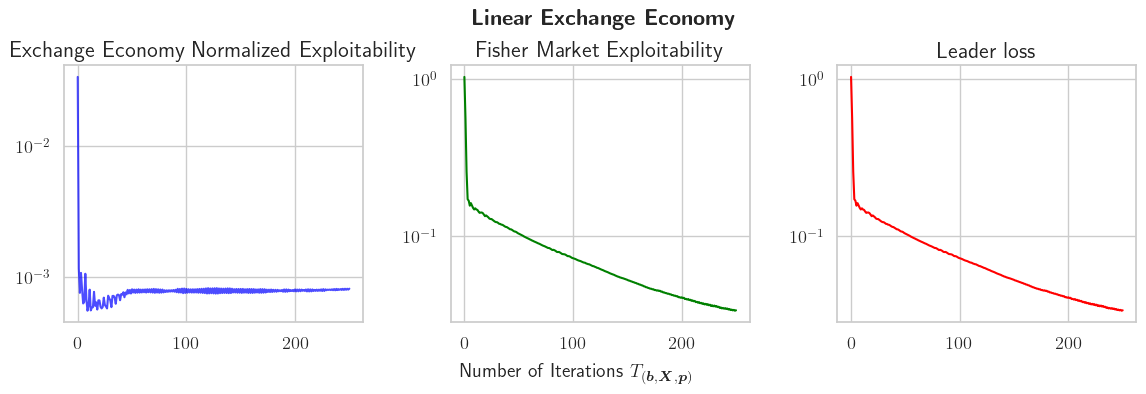

In [ ]:
plot_loss_graphs(exploit_hist_linear, follower_regrets_linear, leader_payoffs_linear, title = "Linear Exchange Economy")

# Cobb-Douglas Arrow-Debreu Market

In [ ]:
util_type = "cd"

## Stackelberg-Nash Game Definitions 

In [ ]:
@jax.jit
def exploitability(allocations, prices, market):
    """Computes exploitability of allocations and prices for market.
    Args:
      allocations: Allocations of goods to traders
      prices: Prices of goods
      market: An Arrow-Debreu market jnp.ndarray[endowments, valuations]
    Returns:
      Exploitability associated with input allocations, prices, in the inputted
      market.
    """
    endowments = jnp.clip(market["endowments"], a_min=1e-8)
    valuations = jnp.clip(market["valuations"], a_min=1e-8)
    rho = market["rho"]
    allocations = jnp.clip(allocations, a_min=1e-8)
    prices = jnp.clip(prices, a_min=1e-8)
    
    # Jax util functions
    if util_type == "linear":
        def get_utils(allocs):
            return jnp.sum(jnp.multiply(allocs, valuations), axis=1)

        def get_indirect_util(p, b, v, rho):
            _ = rho
            return get_linear_indirect_util(p, b, v)
    elif util_type == "leontief":
        def get_utils(allocs):
            return jnp.min((allocs / valuations), axis=1)

        def get_indirect_util(p, b, v, rho):
            _ = rho
            return get_leontief_indirect_util(p, b, v)
    elif util_type == "cd":
        # Valuations need to be normalized to compute correct solutions in closed
        # form
        valuations = (valuations.T / jnp.sum(valuations, axis=1)).T

        def get_utils(allocs):
            return jnp.prod(jnp.power(allocs, valuations), axis=1)

        def get_indirect_util(p, b, v, rho):
            _ = rho
            return get_CD_indirect_util(p, b, v)
    elif util_type == "ces":
        def get_utils(allocs):
            return jnp.power(
                jnp.sum(jnp.power(allocs.T, rho).T * valuations, axis=1), (1 / rho))

        def get_indirect_util(p, b, v, rho):
            return get_ces_indirect_util(p, b, v, rho)
    get_indirect_utils = jax.vmap(
        get_indirect_util, in_axes=[None, 0, 0, 0])

    return jnp.max(jnp.sum(allocations, axis=0) - jnp.sum(
        endowments, axis=0)) - prices.T @ (jnp.sum(
            allocations, axis=0) - jnp.sum(endowments, axis=0)) + jnp.sum(
                (get_indirect_utils(prices, endowments @ prices, valuations,
                                    rho) - get_utils(allocations)))
@jax.jit            
def get_fisher_exploit(budgets, allocations, prices, market):
  endowments = jnp.clip(market["endowments"], a_min=1e-8)
  valuations = jnp.clip(market["valuations"], a_min=1e-8)
  rho = market["rho"]
  allocations = jnp.clip(allocations, a_min=1e-8)
  prices = jnp.clip(prices, a_min=1e-8)

  # Jax util functions
  if util_type == "linear":
      def get_utils(allocs):
          return jnp.sum(jnp.multiply(allocs, valuations), axis=1)

      def get_indirect_util(p, b, v, rho):
          _ = rho
          return get_linear_indirect_util(p, b, v)
  
  elif util_type == "leontief":
      def get_utils(allocs):
          return jnp.min((allocs / valuations), axis=1)

      def get_indirect_util(p, b, v, rho):
          _ = rho
          return get_leontief_indirect_util(p, b, v)
  
  elif util_type == "cd":
      # Valuations need to be normalized to compute correct solutions in closed
      # form
      valuations = (valuations.T / jnp.sum(valuations, axis=1)).T

      def get_utils(allocs):
          return jnp.prod(jnp.power(allocs, valuations), axis=1)

      def get_indirect_util(p, b, v, rho):
          _ = rho
          return get_CD_indirect_util(p, b, v)
  
  elif util_type == "ces":
      def get_utils(allocs):
          return jnp.power(
              jnp.sum(jnp.power(allocs.T, rho).T * valuations, axis=1), (1 / rho))

      def get_indirect_util(p, b, v, rho):
          return get_ces_indirect_util(p, b, v, rho)
  get_indirect_utils = jax.vmap(
        get_indirect_util, in_axes=[None, 0, 0, 0])
  
  buyer_regret = jnp.sum((get_indirect_utils(prices, budgets, valuations,
                                    rho) - get_utils(allocations)))
  excess_demand = jnp.sum(jnp.sum(allocations, axis = 0) - 1)
  excess_demand_squared = jnp.linalg.norm(excess_demand)

  return jnp.squeeze(excess_demand_squared + buyer_regret)


@jax.jit
def leader_payoff(actions, market):
  budgets, allocations, prices = actions
  endowments =  market["endowments"]
  return -jnp.linalg.norm(budgets - endowments @ prices)

@jax.jit
def follower_payoff(actions, market):
    budgets, allocations, prices = actions
    endowments = jnp.clip(market["endowments"], a_min=1e-8)
    valuations = jnp.clip(market["valuations"], a_min=1e-8)
    rho = market["rho"]

    # Jax util functions
    if util_type == "linear":
        def get_utils(allocs):
            return jnp.sum(jnp.multiply(allocs, valuations), axis=1)
        utils = budgets.T @ jnp.log(get_utils(allocations))

    elif util_type == "leontief":
        def get_utils(allocs):
            return jnp.min((allocs / valuations), axis=1)
        utils = budgets.T @ jnp.log(get_utils(allocations))
    
    elif util_type == "cd":
        # Valuations need to be normalized to compute correct solutions in closed
        # form
        valuations = (valuations.T / jnp.sum(valuations, axis=1)).T

        def get_utils(allocs):
            return jnp.sum(valuations*jnp.log(allocs + 1e-3), axis=1)
        utils = budgets.T @ get_utils(allocations)

    elif util_type == "ces":
        def get_utils(allocs):
            return jnp.power(
                jnp.sum(jnp.power(allocs.T, rho).T * valuations, axis=1), (1 / rho))
        utils = budgets.T @ jnp.log(get_utils(allocations))
    
    # jax.debug.print("UTILS {utils}", utils = utils)
    # excess_spending = jnp.sum(budgets - allocations @ prices)
    # revenue = jnp.sum(prices)
    profit = jnp.sum(prices) - jnp.sum(allocations @ prices)
    return jnp.squeeze(utils + profit)

@jax.jit
def follower_regret(actions, f_br_actions, market):
  budgets, allocations, prices = actions
  br_allocations, br_prices = f_br_actions
  return follower_payoff((budgets, br_allocations, prices), market) - follower_payoff((budgets, allocations, br_prices), market)

@jax.jit
def lagrangian_function(actions, f_br_actions, langmult, market):
  budgets, allocations, prices = actions
  br_allocations, br_prices = f_br_actions
  l_payoff = leader_payoff(actions, market)
  f_regret = follower_regret(actions, f_br_actions, market)
  penalty_func = jnp.squeeze(l_payoff + langmult*f_regret)

  return penalty_func

@jax.jit
def penalty_function(actions, f_br_actions, langmult, beta, market):
  budgets, allocations, prices = actions
  br_allocations, br_prices = f_br_actions
  l_payoff = leader_payoff(actions, market)
  f_regret = follower_regret(actions, f_br_actions, market)
  penalty_func = jnp.squeeze(l_payoff + langmult*f_regret - (beta/2)*jnp.power(f_regret, 2))

  return penalty_func

## Augmented Lagrangian Method

In [ ]:
def run_augmented_lagranian(learn_rate_regret, learn_rate_players, learn_rate_langmult, beta_mult, beta, num_iters_regret, num_iters_players, num_iters_langmult, market):

  @jax.jit
  def regret_step(actions, f_br_actions, learn_rate, market):
    
    @jax.jit
    def project_followers(actions):
      X, p = actions
      
      allocs_next = jnp.clip(X, a_min = 1e-8, a_max = 1.0) 
      prices_next = jnp.clip(p, a_min = 1e-8, a_max = 1.0)

      return (allocs_next, prices_next)

    obj = lambda x: follower_regret(actions, x, market)
    allocations_next, prices_next = gradient_ascent_step(f_br_actions, learn_rate, obj, project_followers)

    allocations, prices = f_br_actions
    norm_change = jnp.mean(jnp.square(allocations_next - allocations)) + jnp.mean(jnp.square(prices_next - prices))

    return ((allocations_next, prices_next), norm_change)

  @jax.jit
  def player_step(actions, f_br_actions, langmult, beta, learn_rate, market):
    
    @jax.jit
    def project_players(actions):
      b, X, p = actions
      proj_simplex = lambda x: jnp.clip(jaxopt.projection.projection_simplex(x), a_min = 1e-8, a_max = 1.0)
      budgets_next = proj_simplex(b)
      allocs_next = jnp.clip(X, a_min = 1e-8, a_max = 1.0)
      prices_next = jnp.clip(p, a_min = 1e-8, a_max = 1.0)
      
      return (budgets_next, allocs_next, prices_next)

    obj = lambda x: penalty_function(x, f_br_actions, langmult, beta, market)
    
    budgets_next, allocations_next, prices_next = gradient_ascent_step(actions, learn_rate, obj, project_players)

    budgets, allocations, prices = actions
    norm_change = jnp.linalg.norm(allocations_next - allocations) + jnp.linalg.norm(prices_next - prices) + jnp.linalg.norm(budgets_next - budgets)
    return ((budgets_next, allocations_next, prices_next), norm_change)

  @jax.jit
  def langmult_step(actions, f_br_actions, langmult, beta, learn_rate, market):
    obj = lambda x: penalty_function(actions, f_br_actions, x, beta, market)
    langmult_next = gradient_descent_step(langmult, learn_rate, obj)
    return langmult_next
    
  budgets, allocations, prices = random_outcome(num_samples, num_buyers, num_goods, market)
  _, br_allocations, br_prices = random_outcome(num_samples, num_buyers, num_goods, market)
  actions = (budgets, allocations, prices)
  f_br_actions = (br_allocations, br_prices)
  langmult = -np.random.rand(1)

  iter_langmult = 0
  iter_player = 0
  iter_regret = 0

  allocs_hist = []
  prices_hist = []
  budgets_hist = []
  exploit_hist = []
  leader_payoffs = []
  follower_regrets = []
  
  exploit_train = float("inf")
  budget_samples, allocation_samples, price_samples = random_outcome(100, num_buyers, num_goods, market)
  avg_exploit = jnp.mean(jax.vmap(exploitability, in_axes = [0,0, None])(allocation_samples, price_samples, market))

  print("Lagrange multiplier", langmult)
  while iter_langmult <= num_iters_langmult and abs(exploit_train) > 1e-3:
    print(f"\033[1m============================================================ Lagrangian Iteration -- {iter_langmult} ============================================================\033[0m")
    _, allocations, prices = actions
    exploit_train = exploitability(allocations, prices, market)/avg_exploit
    fisher_exploit = get_fisher_exploit(*actions, market)
    leader_util = leader_payoff(actions, market)
    print(f"\t\t\t\t\t\t\t\033[1mLeader utility {leader_util:.4f}\033[0m")
    print(f"\t\t\t\t\033[1mArrow-Debreu Exploitability {exploit_train:.4f} - Excess Demand {jnp.sum(allocations - market['endowments'], axis = 0)[:3]}\033[0m")
    print(f"\t\t\t\t\t\t\t\033[1mFisher Exploitability {fisher_exploit:.4f}\033[0m")
    print(f"\t\t\t\t\t\t\t\033[1mPenalty Function Value {penalty_function(actions, f_br_actions, langmult, beta, market):.4f}\033[0m")

    exploit_hist.append(exploit_train)
    
    leader_payoffs.append(leader_util)

    iter_player = 0
    action_norm_change = float("inf")
    while iter_player <= num_iters_players or action_norm_change > 1e-4:
      
      if iter_player % 2500 == 0:
        print(f"\t\t\t\t  **************************** Lagrangian Iteration: {iter_langmult} // Player Iteration: {iter_player}  ****************************    ")
    
      iter_regret = 0
      br_norm_change = float("inf")
      while iter_regret <= num_iters_regret and br_norm_change > 1e-8:
        # if iter_player % 2500 == 0 and iter_regret % 250 == 0:
        #   print(f"\t\t\t\t\t\t\t----- Regret Iteration: {iter_regret} -----       ")
          # print(f"\t\t\t\t\t\t\tRegret Norm Change {br_norm_change:.4f}        ")
        # Update step w/ decay
        decaying_learn_rate_regret = learn_rate_regret/jnp.sqrt(iter_regret + 1)
        budgets, allocations, prices = actions
        f_br_actions, br_norm_change = regret_step(actions, f_br_actions, decaying_learn_rate_regret, market)
        # if iter_langmult % 5 == 0 and iter_player % 1 == 0 and iter_regret % 250 == 0:


        iter_regret += 1
      
      follower_reg = follower_regret(actions, f_br_actions, market)
      follower_regrets.append(follower_reg)

      # Update step w/ decay
      decaying_learn_rate_players = learn_rate_players/(jnp.sqrt(iter_player + iter_langmult  + 1))
      actions, action_norm_change = player_step(actions, f_br_actions, langmult, beta, decaying_learn_rate_players, market)
      
      


      if iter_player % 2500 == 0:
        budgets_hist.append(actions[0])
        allocs_hist.append(actions[1])
        prices_hist.append(actions[2])
        _, allocations, prices = actions
        leader_util = leader_payoff(actions, market)
        print("\t\t\t\t\t\t\t\ttotal spending", jnp.sum(allocations @ prices))
        print("\t\t\t\t\t\t\t\ttotal endowment", jnp.sum(market["endowments"] @ prices))
        print("\t\t\t\t\t\t\t\tPrices", prices[:3])
        print("\t\t\t\t\t\t\t\t----------------------------")
        print(f"\t\t\t\t\t\t\t\033[1mLeader utility {leader_util:.4f}\033[0m")
        print(f"\t\t\t\t\t\t\tRegret Norm Change {br_norm_change:.6f}        ")
        print(f"\t\t\t\t\t\t\tRegret {follower_reg:.4f}        ")
        print(f"\t\t\t\t\t\t\tAction Norm Change {action_norm_change:.6f}     ")
        print(f"\t\t\t\t\t\t\t\033[1mExcess Demand {jnp.sum(allocations - market['endowments'], axis = 0)[:3]}\033[0m")
        print(f"\t\t\t\t\t\t\t\033[1mFisher Exploitability {get_fisher_exploit(*actions, market):.4f}\033[0m")
        print(f"\t\t\t\t\t\t\tPenalty Function Value {penalty_function(actions, f_br_actions, langmult, beta, market):.4f}")
      iter_player += 1
    
    decaying_learn_rate_langmult = learn_rate_langmult/jnp.square(iter_langmult + 1)
    langmult = langmult_step(actions, f_br_actions, langmult, beta, decaying_learn_rate_langmult, market)
    print(f"Lagrange Multipliers {langmult}")
    print(f"Beta {beta}")
    beta *= beta_mult
    iter_langmult += 1

  return ((exploit_hist, follower_regrets, leader_payoffs), (budgets_hist, allocs_hist, prices_hist))

## Experiment

In [ ]:
num_buyers = 10
num_goods = 10
num_samples = 1
subst_range = 0.5
learn_rate_regret = 0.01
learn_rate_players = 0.001
learn_rate_langmult = 0.1
beta = 1
beta_mult = 1.005

num_iters_regret = 500
num_iters_players = 500
num_iters_langmult = 250

market = sample_markets(num_buyers, num_goods, num_samples, subst_range, seed)
(exploit_hist_cd, follower_regrets_cd, leader_payoffs_cd), actions_hist = run_augmented_lagranian(learn_rate_regret, learn_rate_players, learn_rate_langmult, beta_mult, beta, num_iters_regret, num_iters_players, num_iters_langmult, market)

Lagrange multiplier [-0.3506]
============================================================ Lagrangian Iteration -- 0 ============================================================
							Leader utility -0.4187
				Arrow-Debreu Exploitability 2.4189 - Excess Demand [0.2121 115.5092 0.6255]
							Fisher Exploitability 6144.8364
							Penalty Function Value -0.4187
				  **************************** Lagrangian Iteration: 0 // Player Iteration: 0  ****************************    
								total spending 12.193461
								total endowment 2.4419942
								Prices [0.0843 1.0000 0.1326]
								----------------------------
							Leader utility -0.6367
							Regret Norm Change 0.000000        
							Regret 119.9279        
							Action Norm Change 54.049622     
							Excess Demand [0.0541 9.0000 0.2839]
							Fisher Exploitability -32.6938
							Penalty Function Value -2.7161
				  **************************** Lagrangian Iteration: 0 // Player Iteration: 2500  **************************

## Results

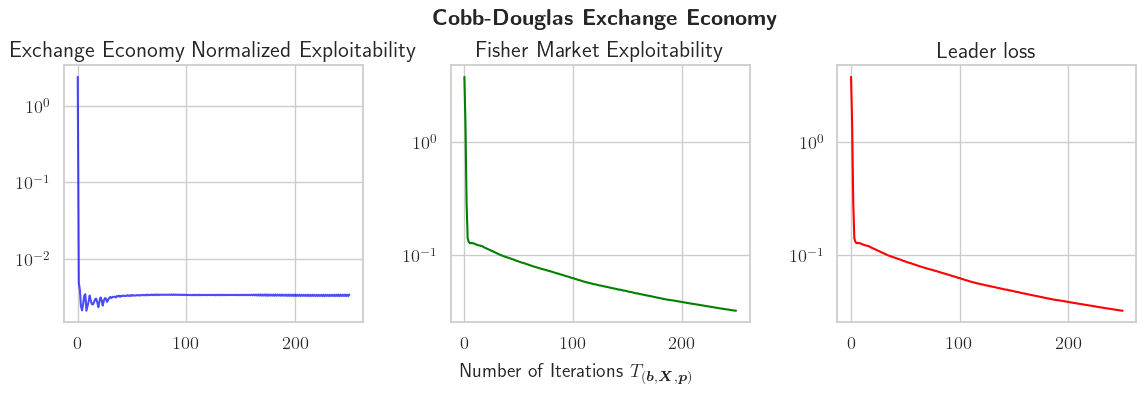

In [ ]:
plot_loss_graphs(exploit_hist_linear, follower_regrets_linear, leader_payoffs_linear, title = "Cobb-Douglas Exchange Economy")

# Leontief Arrow-Debreu Economy

In [ ]:
util_type = "leontief"

## Stackelberg-Nash Game Definitions 

In [ ]:
@jax.jit
def exploitability(allocations, prices, market):
    """Computes exploitability of allocations and prices for market.
    Args:
      allocations: Allocations of goods to traders
      prices: Prices of goods
      market: An Arrow-Debreu market jnp.ndarray[endowments, valuations]
    Returns:
      Exploitability associated with input allocations, prices, in the inputted
      market.
    """
    endowments = jnp.clip(market["endowments"], a_min=1e-8)
    valuations = jnp.clip(market["valuations"], a_min=1e-8)
    rho = market["rho"]
    allocations = jnp.clip(allocations, a_min=1e-8)
    prices = jnp.clip(prices, a_min=1e-8)
    
    # Jax util functions
    if util_type == "linear":
        def get_utils(allocs):
            return jnp.sum(jnp.multiply(allocs, valuations), axis=1)

        def get_indirect_util(p, b, v, rho):
            _ = rho
            return get_linear_indirect_util(p, b, v)
    elif util_type == "leontief":
        def get_utils(allocs):
            return jnp.min((allocs / valuations), axis=1)

        def get_indirect_util(p, b, v, rho):
            _ = rho
            return get_leontief_indirect_util(p, b, v)
    elif util_type == "cd":
        # Valuations need to be normalized to compute correct solutions in closed
        # form
        valuations = (valuations.T / jnp.sum(valuations, axis=1)).T

        def get_utils(allocs):
            return jnp.prod(jnp.power(allocs, valuations), axis=1)

        def get_indirect_util(p, b, v, rho):
            _ = rho
            return get_CD_indirect_util(p, b, v)
    elif util_type == "ces":
        def get_utils(allocs):
            return jnp.power(
                jnp.sum(jnp.power(allocs.T, rho).T * valuations, axis=1), (1 / rho))

        def get_indirect_util(p, b, v, rho):
            return get_ces_indirect_util(p, b, v, rho)
    get_indirect_utils = jax.vmap(
        get_indirect_util, in_axes=[None, 0, 0, 0])

    return jnp.max(jnp.sum(allocations, axis=0) - jnp.sum(
        endowments, axis=0)) - prices.T @ (jnp.sum(
            allocations, axis=0) - jnp.sum(endowments, axis=0)) + jnp.sum(
                (get_indirect_utils(prices, endowments @ prices, valuations,
                                    rho) - get_utils(allocations)))

@jax.jit            
def get_fisher_exploit(budgets, allocations, prices, market):
  endowments = jnp.clip(market["endowments"], a_min=1e-8)
  valuations = jnp.clip(market["valuations"], a_min=1e-8)
  rho = market["rho"]
  allocations = jnp.clip(allocations, a_min=1e-8)
  prices = jnp.clip(prices, a_min=1e-8)

  # Jax util functions
  if util_type == "linear":
      def get_utils(allocs):
          return jnp.sum(jnp.multiply(allocs, valuations), axis=1)

      def get_indirect_util(p, b, v, rho):
          _ = rho
          return get_linear_indirect_util(p, b, v)
  
  elif util_type == "leontief":
      def get_utils(allocs):
          return jnp.min((allocs / valuations), axis=1)

      def get_indirect_util(p, b, v, rho):
          _ = rho
          return get_leontief_indirect_util(p, b, v)
  
  elif util_type == "cd":
      # Valuations need to be normalized to compute correct solutions in closed
      # form
      valuations = (valuations.T / jnp.sum(valuations, axis=1)).T

      def get_utils(allocs):
          return jnp.prod(jnp.power(allocs, valuations), axis=1)

      def get_indirect_util(p, b, v, rho):
          _ = rho
          return get_CD_indirect_util(p, b, v)
  
  elif util_type == "ces":
      def get_utils(allocs):
          return jnp.power(
              jnp.sum(jnp.power(allocs.T, rho).T * valuations, axis=1), (1 / rho))

      def get_indirect_util(p, b, v, rho):
          return get_ces_indirect_util(p, b, v, rho)
  get_indirect_utils = jax.vmap(
        get_indirect_util, in_axes=[None, 0, 0, 0])
  
  buyer_regret = jnp.sum((get_indirect_utils(prices, budgets, valuations,
                                    rho) - get_utils(allocations)))
  excess_demand = jnp.sum(jnp.sum(allocations, axis = 0) - 1)
  excess_demand_squared = jnp.linalg.norm(excess_demand)

  return jnp.squeeze(excess_demand_squared + buyer_regret)


@jax.jit
def leader_payoff(actions, market):
  budgets, allocations, prices = actions
  endowments =  market["endowments"]
  return -jnp.linalg.norm(budgets - endowments @ prices)

@jax.jit
def follower_payoff(actions, market):
    budgets, allocations, prices = actions
    endowments = jnp.clip(market["endowments"], a_min=1e-8)
    valuations = jnp.clip(market["valuations"], a_min=1e-8)
    rho = market["rho"]

    # Jax util functions
    if util_type == "linear":
        def get_utils(allocs):
            return jnp.sum(jnp.multiply(allocs, valuations), axis=1)

    elif util_type == "leontief":
        def get_utils(allocs):
            return jnp.min((allocs / valuations), axis=1)

    elif util_type == "cd":
        # Valuations need to be normalized to compute correct solutions in closed
        # form
        valuations = (valuations.T / jnp.sum(valuations, axis=1)).T

        def get_utils(allocs):
            return jnp.prod(jnp.power(allocs, valuations), axis=1)

    elif util_type == "ces":
        def get_utils(allocs):
            return jnp.power(
                jnp.sum(jnp.power(allocs.T, rho).T * valuations, axis=1), (1 / rho))
    
    utils = budgets.T @ jnp.log(get_utils(allocations))
    
    profit = jnp.sum(prices) - jnp.sum(allocations @ prices)
    return jnp.squeeze(utils + profit)

@jax.jit
def follower_regret(actions, f_br_actions, market):
  budgets, allocations, prices = actions
  br_allocations, br_prices = f_br_actions
  return follower_payoff((budgets, br_allocations, prices), market) - follower_payoff((budgets, allocations, br_prices), market) 
  # + 2*budgets.T @ jnp.log(budgets)

@jax.jit
def lagrangian_function(actions, f_br_actions, langmult, market):
  budgets, allocations, prices = actions
  br_allocations, br_prices = f_br_actions
  l_payoff = leader_payoff(actions, market)
  f_regret = follower_regret(actions, f_br_actions, market)
  penalty_func = jnp.squeeze(l_payoff + langmult*f_regret)

  return penalty_func

@jax.jit
def penalty_function(actions, f_br_actions, langmult, beta, market):
  budgets, allocations, prices = actions
  br_allocations, br_prices = f_br_actions
  l_payoff = leader_payoff(actions, market)
  f_regret = follower_regret(actions, f_br_actions, market)
  penalty_func = jnp.squeeze(l_payoff + langmult*f_regret - (beta/2)*jnp.power(f_regret, 2))

  return penalty_func

## Augmented Lagrangian Method

In [ ]:
def run_augmented_lagranian(learn_rate_regret, learn_rate_players, learn_rate_langmult, beta_mult, beta, num_iters_regret, num_iters_players, num_iters_langmult, market):

  @jax.jit
  def regret_step(actions, f_br_actions, learn_rate, market):
    
    @jax.jit
    def project_followers(actions):
      X, p = actions
      
      allocs_next = jnp.clip(X, a_min = 1e-8, a_max = 1.0) 
      prices_next = jnp.clip(p, a_min = 1e-8, a_max = 1.0)

      return (allocs_next, prices_next)

    obj = lambda x: follower_regret(actions, x, market)
    allocations_next, prices_next = gradient_ascent_step(f_br_actions, learn_rate, obj, project_followers)

    allocations, prices = f_br_actions
    norm_change = jnp.mean(jnp.square(allocations_next - allocations)) + jnp.mean(jnp.square(prices_next - prices))

    return ((allocations_next, prices_next), norm_change)

  @jax.jit
  def player_step(actions, f_br_actions, langmult, beta, learn_rate, market):
    
    @jax.jit
    def project_players(actions):
      b, X, p = actions
      proj_simplex = lambda x: jnp.clip(jaxopt.projection.projection_simplex(x), a_min = 1e-8, a_max = 1.0)
      budgets_next = proj_simplex(b)
      allocs_next = jnp.clip(X, a_min = 1e-8, a_max = 1.0)
      prices_next = jnp.clip(p, a_min = 1e-8, a_max = 1.0)
      
      return (budgets_next, allocs_next, prices_next)

    obj = lambda x: penalty_function(x, f_br_actions, langmult, beta, market)
    
    budgets_next, allocations_next, prices_next = gradient_ascent_step(actions, learn_rate, obj, project_players)

    budgets, allocations, prices = actions
    norm_change = jnp.linalg.norm(allocations_next - allocations) + jnp.linalg.norm(prices_next - prices) + jnp.linalg.norm(budgets_next - budgets)
    return ((budgets_next, allocations_next, prices_next), norm_change)

  @jax.jit
  def langmult_step(actions, f_br_actions, langmult, beta, learn_rate, market):
    obj = lambda x: penalty_function(actions, f_br_actions, x, beta, market)
    langmult_next = gradient_descent_step(langmult, learn_rate, obj)
    return langmult_next
    
  budgets, allocations, prices = random_outcome(num_samples, num_buyers, num_goods, market)
  _, br_allocations, br_prices = random_outcome(num_samples, num_buyers, num_goods, market)
  actions = (budgets, allocations, prices)
  f_br_actions = (br_allocations, br_prices)
  langmult = -np.random.rand(1)

  iter_langmult = 0
  iter_player = 0
  iter_regret = 0

  allocs_hist = []
  prices_hist = []
  budgets_hist = []
  exploit_hist = []
  leader_payoffs = []
  follower_regrets = []
  
  exploit_train = float("inf")
  budget_samples, allocation_samples, price_samples = random_outcome(100, num_buyers, num_goods, market)
  avg_exploit = jnp.mean(jax.vmap(exploitability, in_axes = [0,0, None])(allocation_samples, price_samples, market))

  print("Lagrange multiplier", langmult)
  while iter_langmult <= num_iters_langmult and abs(exploit_train) > 1e-3:
    print(f"\033[1m============================================================ Lagrangian Iteration -- {iter_langmult} ============================================================\033[0m")
    _, allocations, prices = actions
    exploit_train = exploitability(allocations, prices, market)/avg_exploit
    fisher_exploit = get_fisher_exploit(*actions, market)
    leader_util = leader_payoff(actions, market)
    print(f"\t\t\t\t\t\t\t\033[1mLeader utility {leader_util:.4f}\033[0m")
    print(f"\t\t\t\t\033[1mArrow-Debreu Exploitability {exploit_train:.4f} - Excess Demand {jnp.sum(allocations - market['endowments'], axis = 0)[:3]}\033[0m")
    print(f"\t\t\t\t\t\t\t\033[1mFisher Exploitability {fisher_exploit:.4f}\033[0m")
    print(f"\t\t\t\t\t\t\t\033[1mPenalty Function Value {penalty_function(actions, f_br_actions, langmult, beta, market):.4f}\033[0m")

    exploit_hist.append(exploit_train)
    
    leader_payoffs.append(leader_util)

    iter_player = 0
    action_norm_change = float("inf")
    while iter_player <= num_iters_players:
      
      if iter_player % 100 == 0:
        print(f"\t\t\t\t  **************************** Lagrangian Iteration: {iter_langmult} // Player Iteration: {iter_player}  ****************************    ")
    
      iter_regret = 0
      br_norm_change = float("inf")
      while iter_regret <= num_iters_regret and br_norm_change > 1e-8:
        # if iter_player % 100 == 0 and iter_regret % 250 == 0:
        #   print(f"\t\t\t\t\t\t\t----- Regret Iteration: {iter_regret} -----       ")
          # print(f"\t\t\t\t\t\t\tRegret Norm Change {br_norm_change:.4f}        ")
        # Update step w/ decay
        decaying_learn_rate_regret = learn_rate_regret/jnp.sqrt(iter_regret + 1)
        budgets, allocations, prices = actions
        f_br_actions, br_norm_change = regret_step(actions, f_br_actions, decaying_learn_rate_regret, market)
        # if iter_langmult % 5 == 0 and iter_player % 1 == 0 and iter_regret % 250 == 0:


        iter_regret += 1
      
      follower_reg = follower_regret(actions, f_br_actions, market)
      follower_regrets.append(follower_reg)

      # Update step w/ decay
      decaying_learn_rate_players = learn_rate_players/((iter_player  + 1))
      actions, action_norm_change = player_step(actions, f_br_actions, langmult, beta, decaying_learn_rate_players, market)
      
      


      if iter_player % 100 == 0:
        budgets_hist.append(actions[0])
        allocs_hist.append(actions[1])
        prices_hist.append(actions[2])
        _, allocations, prices = actions
        leader_util = leader_payoff(actions, market)
        print("\t\t\t\t\t\t\t\ttotal spending", jnp.sum(allocations @ prices))
        print("\t\t\t\t\t\t\t\ttotal endowment", jnp.sum(market["endowments"] @ prices))
        print("\t\t\t\t\t\t\t\tPrices", prices[:3])
        print("\t\t\t\t\t\t\t\t----------------------------")
        print(f"\t\t\t\t\t\t\t\033[1mLeader utility {leader_util:.4f}\033[0m")
        print(f"\t\t\t\t\t\t\tRegret Norm Change {br_norm_change:.6f}        ")
        print(f"\t\t\t\t\t\t\tRegret {follower_reg:.4f}        ")
        print(f"\t\t\t\t\t\t\tAction Norm Change {action_norm_change:.6f}     ")
        print(f"\t\t\t\t\t\t\t\033[1mExcess Demand {jnp.sum(allocations - market['endowments'], axis = 0)[:3]}\033[0m")
        print(f"\t\t\t\t\t\t\t\033[1mFisher Exploitability {get_fisher_exploit(*actions, market):.4f}\033[0m")
        print(f"\t\t\t\t\t\t\tPenalty Function Value {penalty_function(actions, f_br_actions, langmult, beta, market):.4f}")
      iter_player += 1
    
    decaying_learn_rate_langmult = learn_rate_langmult/jnp.square(iter_langmult + 1)
    langmult = langmult_step(actions, f_br_actions, langmult, beta, decaying_learn_rate_langmult, market)
    print(f"Lagrange Multipliers {langmult}")
    print(f"Beta {beta}")
    beta *= beta_mult
    iter_langmult += 1

  return ((exploit_hist, follower_regrets, leader_payoffs), (budgets_hist, allocs_hist, prices_hist))

## Experiment

In [24]:
num_buyers = 5
num_goods = 5
num_samples = 1
subst_range = 0.5
learn_rate_regret = 0.01
learn_rate_players = 0.05
learn_rate_langmult = 0.1
beta = 1
beta_mult = 1.005

num_iters_regret = 500
num_iters_players = 500
num_iters_langmult = 250

market = sample_markets(num_buyers, num_goods, num_samples, subst_range, seed)
(exploit_hist_leontief, follower_regrets_leontief, leader_payoffs_leontief), actions_hist = run_augmented_lagranian(learn_rate_regret, learn_rate_players, learn_rate_langmult, beta_mult, beta, num_iters_regret, num_iters_players, num_iters_langmult, market)

Lagrange multiplier [-0.6336]
============================================================ Lagrangian Iteration -- 0 ============================================================
							Leader utility -0.4356
				Arrow-Debreu Exploitability 0.3278 - Excess Demand [-0.3827 0.3831 4.8617]
							Fisher Exploitability 4.6214
							Penalty Function Value -0.4356
				  **************************** Lagrangian Iteration: 0 // Player Iteration: 0  ****************************    
								total spending 4.671319
								total endowment 2.0797818
								Prices [0.1579 0.2656 1.0000]
								----------------------------
							Leader utility -0.8804
							Regret Norm Change 0.000000        
							Regret 7.6359        
							Action Norm Change 4.471017     
							Excess Demand [2.1664 -0.2463 1.7921]
							Fisher Exploitability 4.6951
							Penalty Function Value -75.6041
				  **************************** Lagrangian Iteration: 0 // Player Iteration: 100  ****************************    
		

## Results

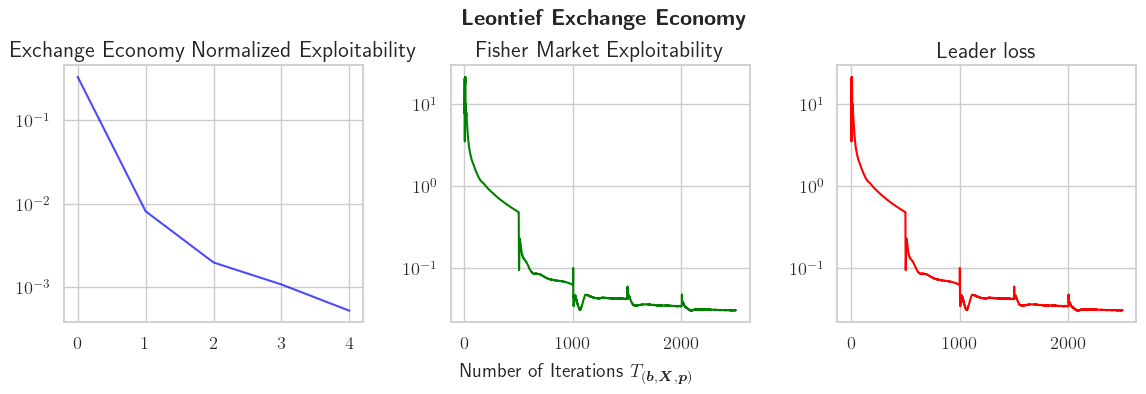

In [25]:
plot_loss_graphs(exploit_hist_leontief, follower_regrets_leontief, leader_payoffs_leontief, title = "Leontief Exchange Economy")